### Convolutional network: 
---
- traditionally used for image processing
- outperform recurrent neural network recently
- accepts two/ three dimensional data
- convolution: locate features of an image
- convolution kernel/ window: find edges, curves, corners, combination of pixels, 
- next kernel layer: find circles, combination of edges, curves, corners
- next kernel layer: find combination of circles, ...
- max pooling
- drastically simplifying the image into features
- one-hot vector

#### Data: cats vs dogs microsoft dataset
---
- images varying in sizes, shape
- solutions:
    - reshape the image, image would be distorted, but there is still difference between cats and dogs
    - maintain the aspect ratio and add padding
    - shift the image
    
---
### Build convnet
 


In [1]:
import os
import cv2 # opencv-python
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogsVSCats():
    # 50 x 50 
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS:0, DOGS:1}
    
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            # tqdm: gives a progress bar
            # loop through each image
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    
                    # convert image to greyscale
                    # color doesn't add a dimension, it adds a channel
                    # is color a relevant feature to distinguish a cat and a dog? No
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    
                    # convert scalar values to one-hot vector using np.eye()
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                    # print(str(e))
                
        # shuffle data
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        
        # makes sure data is balanced
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
    

In [2]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

- 12476/12500: we lost 20-ish images
- Thumbs.db caused the error

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [4]:
len(training_data)

24946

- [1,0] is a cat
- [0,1] is a dog

In [5]:
training_data[0]

array([array([[202, 210, 214, ..., 196, 147, 216],
       [195, 193, 153, ..., 199, 198, 202],
       [200, 204, 200, ..., 205, 208, 189],
       ...,
       [229, 225, 215, ..., 220, 206,  83],
       [215, 227, 236, ..., 226, 229, 205],
       [229, 227, 223, ..., 213, 211, 214]], dtype=uint8),
       array([0., 1.])], dtype=object)

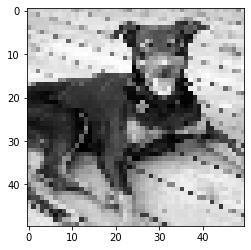

In [9]:
import matplotlib.pyplot as plt
# color map
plt.imshow(training_data[0][0], cmap="gray")
plt.show()

### Training Convnet
---

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input, Output, Kernel size
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        # -1 means however the shape it is
        x = torch.randn(50, 50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        # output is 2 because there are 2 classes
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        # Pass data through all layers
        x = self.convs(x)
        
        # Flatten it
        x = x.view(-1, self._to_linear)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # activation layer, specify dim because of batches
        return F.softmax(x, dim=1)
        
        
net = Net()


torch.Size([128, 2, 2])


In [14]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
# Mean square error
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0

y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)


2494


In [16]:
# array slicing
# until end-val_size
train_X = X[:-val_size]
train_y = y[:-val_size]

# starting at val_size to the end
test_X = X[-val_size:]
test_y = X[-val_size:]

print(len(train_X))
print(len(test_X))


22452
2494


In [18]:
BATCH_SIZE = 100
EPOCHS = 1


for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        # print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        


100%|██████████| 225/225 [00:00<00:00, 11110.02it/s]

0 100
100 200
200 300
300 400
400 500
500 600
600 700
700 800
800 900
900 1000
1000 1100
1100 1200
1200 1300
1300 1400
1400 1500
1500 1600
1600 1700
1700 1800
1800 1900
1900 2000
2000 2100
2100 2200
2200 2300
2300 2400
2400 2500
2500 2600
2600 2700
2700 2800
2800 2900
2900 3000
3000 3100
3100 3200
3200 3300
3300 3400
3400 3500
3500 3600
3600 3700
3700 3800
3800 3900
3900 4000
4000 4100
4100 4200
4200 4300
4300 4400
4400 4500
4500 4600
4600 4700
4700 4800
4800 4900
4900 5000
5000 5100
5100 5200
5200 5300
5300 5400
5400 5500
5500 5600
5600 5700
5700 5800
5800 5900
5900 6000
6000 6100
6100 6200
6200 6300
6300 6400
6400 6500
6500 6600
6600 6700
6700 6800
6800 6900
6900 7000
7000 7100
7100 7200
7200 7300
7300 7400
7400 7500
7500 7600
7600 7700
7700 7800
7800 7900
7900 8000
8000 8100
8100 8200
8200 8300
8300 8400
8400 8500
8500 8600
8600 8700
8700 8800
8800 8900
8900 9000
9000 9100
9100 9200
9200 9300
9300 9400
9400 9500
9500 9600
9600 9700
9700 9800
9800 9900
9900 10000
10000 10100
10100 10